In [2]:
## Useful for importing libraries on Google cloud. libraries are in Notebooks/libs folder
import sys
sys.path.insert(0, 'libs')

In [5]:
import numpy as np
import keras 
import pandas as pd
from sqlalchemy import create_engine

from random import randint
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [16]:
from google.cloud import storage

from io import BytesIO

client = storage.Client()

bucket = "dataham"

In [23]:
filename_keras = "/Generated_KERAS/images_augmented.npy"

blob = storage.blob.Blob(filename_keras, bucket)

## IMPORTANT FUNCTIONS 

In [4]:
####### SHUFFLE DATA ####### 
def shuffle_data(X, Y):
    nb_rows = X.shape[0]
    index_rand = np.arange(nb_rows)
    np.random.shuffle(index_rand)
    X_shuffle, Y_shuffle = X[index_rand], Y[index_rand]
    return X_shuffle, Y_shuffle

In [5]:
def concat_train_label(X1, X2, Y1, Y2):
    nb_obs = X1.shape[0] + X2.shape[0]
    X_aug = np.empty((nb_obs, 128, 128, 3))
    Y_aug = np.empty((nb_obs,))
    nb_obs_or = X1.shape[0]
    
    for k in range(X1.shape[0]):
        X_aug[k] = X1[k]
        Y_aug[k] = Y1[k]
    
    iteration = 0
    while iteration != Y2.shape[0]:
        X_aug[iteration+nb_obs_or] = X2[iteration]
        Y_aug[iteration+nb_obs_or] = Y2[iteration]
        iteration += 1
        
    return X_aug, Y_aug

In [31]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(model, x_val = x_val, y_val = y_val, classes = np.array([0,1]),
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    
    y_pred = model.predict_classes(x_val)
    y_true = y_val 
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#     print(cm)
    
    fig, ax = plt.subplots(figsize = (15,10))
    #fig = plt.figure((15,10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

# Plot non-normalized confusion matrix
# plot_confusion_matrix(model_best2)

# Plot normalized confusion matrix
# plot_confusion_matrix(model_best2, normalize = True)

# plt.show()

# DATA

######### DATASET  ######


*** Class MEL: training: 698 , validation: 190

*** Class NV: training: 4290 , validation: 1058

In [3]:
#### FROM ORIGINAL DATASET WITHOUT KERAS #####

#### LOAD DATA FROM LOCAL STORAGE ### 

###### MEL: class 1 ######
x_mel_train, x_mel_test = np.load("./dataset/train_mel.npy"), np.load("./dataset/test_mel.npy")
y_mel_train, y_mel_test = np.ones((x_mel_train.shape[0], )), np.ones((x_mel_test.shape[0], ))


###### NV: class 0 ######
x_nv_train, x_nv_test = np.load("./dataset/train_nv.npy"), np.load("./dataset/test_nv.npy")
y_nv_train, y_nv_test = np.zeros((x_nv_train.shape[0], )), np.zeros((x_nv_test.shape[0], ))

In [6]:
#### FROM ORIGINAL DATASET TRANSFORMED WITH KERAS #####

#### LOAD DATA FROM LOCAL STORAGE ### 

filename_local_images_keras = './data_keras/images_augmented.npy'
filename_local_labels_keras = './data_keras/labels_augmented.npy'

array_images_ker = np.load(filename_local_images_keras)
array_labels_ker = np.load(filename_local_labels_keras)

In [4]:
# del array_images_ker, array_labels_ker

In [54]:
nb_nv = np.sum(array_labels_ker == 0) ## nv with class label 0
nb_mel = np.sum(array_labels_ker == 1) ## mel with class label 1

print ("We have {} images of class nv.".format(nb_nv))

print("=================================")

print ("We have {} images of class mel.".format(nb_mel))

We have 5348 images of class nv.
We have 888 images of class mel.


In [7]:
######### CAREFUL: THE DATA DOWN HERE IS THE DATA AFTER SOME TRANSF WITH KERAS ##############

def split_data(factor = 0.8):
    """
    Params 
    --------------
    factor: float 
    We want 80% data in train set and 20% in validation set
    Return
    --------------
    x_train, y_train, x_val, y_val
    """
    boundary_val = np.int(6236*factor) # 6236 corresponds to total nb of images
    x_train, y_train = array_images_ker[0:boundary_val], array_labels_ker[0:boundary_val]
    x_val, y_val = array_images_ker[boundary_val:], array_labels_ker[boundary_val:]
    return (x_train, y_train), (x_val, y_val)

(x_train, y_train), (x_val, y_val) = split_data()    

In [77]:
######### ORIGINAL ##########
percentage_nv_org = (nb_nv/(nb_nv+nb_mel))*100
percentage_mel_org = (nb_mel/(nb_nv+nb_mel))*100
print("============= ORIGINAL ==================")
print("Original data, class nv percentage: {}".format(percentage_nv_org))
print("Original data, class mel percentage: {}".format(percentage_mel_org))



###### TRAIN ############
nb_nv_train = np.sum(y_train == 0)
nb_mel_train = np.sum(y_train == 1)
percentage_nv_train = (nb_nv_train/(nb_nv_train+nb_mel_train))*100
percentage_mel_train= (nb_mel_train/(nb_nv_train+nb_mel_train))*100
print("============= TRAINING ==================")
print("Train data, class nv percentage: {}".format(percentage_nv_train))
print("Train data, class mel percentage: {}".format(percentage_mel_train))


########### VAL ##########
nb_nv_val = np.sum(y_val == 0)
nb_mel_val = np.sum(y_val == 1)
percentage_nv_val = (nb_nv_val/(nb_nv_val+nb_mel_val))*100
percentage_mel_val = (nb_mel_val/(nb_nv_val+nb_mel_val))*100
print("============= VALIDATION ==================")
print("Val data, class nv percentage: {}".format(percentage_nv_val))
print("Val data, class mel percentage: {}".format(percentage_mel_val))

============= ORIGINAL ==================
Original data, class nv percentage: 85.76010262989095
Original data, class mel percentage: 14.239897370109045
============= TRAINING ==================
Train data, class nv percentage: 86.00641539695269
Train data, class mel percentage: 13.993584603047312
============= VALIDATION ==================
Val data, class nv percentage: 84.77564102564102
Val data, class mel percentage: 15.224358974358973


# Simple convolutional Layer

In [10]:
from keras import backend as K

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from collections import Counter 
from keras import backend as K
from keras import optimizers
from keras.callbacks import CSVLogger

csv_logger = CSVLogger('log.csv', append=True, separator=';')



def evaluate_classifier_conv(x_train = x_train, y_train = y_train, x_val = x_val, y_val = y_val, img_rows = 128, img_cols = 128, batch_size = 32, epochs = 20, learning_rate = 0.01, dropout = 0.7, log = True):
    """
    Create simple convolutional model to classify data
    Fit data and return fitted model 
    """
    
    K.clear_session()
    np.random.seed(100)

    if K.image_data_format() == 'channels_first':
        x_train = x_train.reshape(x_train.shape[0], 3, img_rows, img_cols)
        x_val = x_val.reshape(x_val.shape[0], 3, img_rows, img_cols)
        input_shape = (3, img_rows, img_cols)
    else:
        x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 3)
        x_val = x_val.reshape(x_val.shape[0], img_rows, img_cols, 3)
        input_shape = (img_rows, img_cols, 3)

    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=(128, 128,3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))


    # initiate RMSprop optimizer
    opt = optimizers.rmsprop(lr=learning_rate, decay = 1e-5)

    model.compile(loss='binary_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    
    if log:
        # Fit data 
        model.fit(x_train, y_train,
                  batch_size=batch_size,
                  epochs=epochs,
                  verbose=1,
                  validation_data=(x_val, y_val),
                    callbacks=[csv_logger])
    else:
         # Fit data 
        model.fit(x_train, y_train,
                  batch_size=batch_size,
                  epochs=epochs,
                  verbose=1,
                  validation_data=(x_val, y_val))

    # Compute final performance on validation data
    score = model.evaluate(x_val, y_val, verbose=0)
    print('Final validation loss:', score[0])
    print('Final validation accuracy:', score[1])
    
    return model  

Using TensorFlow backend.


In [26]:
import tensorflow as tf 
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from collections import Counter 
from keras import backend as K
from keras import optimizers
from keras.callbacks import CSVLogger
from keras.callbacks import ModelCheckpoint

from keras.callbacks import Callback

from sklearn.metrics import f1_score


csv_logger = CSVLogger('log.csv', append=True, separator=';')



    
    
class EarlyStopByF1(Callback):
    def __init__(self, value = 0, verbose = 0):
        super(Callback, self).__init__()
        self.value = value
        self.verbose = verbose

    def f1(self, y_true, y_pred):
        def recall(y_true, y_pred):
            """Recall metric.

            Only computes a batch-wise average of recall.

            Computes the recall, a metric for multi-label classification of
            how many relevant items are selected.
            """
            true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
            possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
            recall = true_positives / (possible_positives + K.epsilon())
            return recall

        def precision(y_true, y_pred):
            """Precision metric.

            Only computes a batch-wise average of precision.

            Computes the precision, a metric for multi-label classification of
            how many selected items are relevant.
            """
            true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
            predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
            precision = true_positives / (predicted_positives + K.epsilon())
            return precision
        precision = precision(y_true, y_pred)
        recall = recall(y_true, y_pred)
        return 2*((precision*recall)/(precision+recall+K.epsilon()))
    
    
    def on_epoch_end(self, epoch, logs={}):
        predict = np.asarray(self.model.predict(self.validation_data[0]))
        target = self.validation_data[1]
        predict = tf.convert_to_tensor(predict, tf.float32)
        target = tf.convert_to_tensor(target, tf.float32)
        score = self.f1(target, predict) # score is now a tf.tensor (necessary for early stopping)
#         print (type(score)) # tensor 
        tensor_value = tf.constant(self.value, shape = (1,))
        with tf.Session() as sess:
            tensor_value_score = sess.run(tf.greater(score, tensor_value))
#             print(sess.run(tf.greater(score, tensor_value))) ## prints [True] when we go beyond self.value
 
        if np.all(tensor_value_score):# if we go beyond our value, we can stop 
            if self.verbose > 0: # print
                print("Epoch %05d: early stopping Threshold" % epoch)
            self.model.stop_training = True


########## Customize Early Stopping ###########
from keras.callbacks import Callback

class EarlyStoppingByAccuracy(Callback):
    """
    When checking the logs we see that sometimes we get a very low val loss/ high val accuracy at some epoch and after we go below such values.
    Solution:  We will check when such accuracy is reached and stop at this very moment 
    
    PARAMS
    --------------------------
    value: int v
    Value that is seen to be passed for a given epoch => If we are beyond it we stop training!! 
    
    """
    def __init__(self, monitor='accuracy', value=0.85, verbose=0):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)

        if current >= self.value:
            if self.verbose > 0:
                print("Epoch %05d: early stopping THR" % epoch)
            self.model.stop_training = True
            
def evaluate_classifier_conv_custom_fscore(x_train, y_train, x_val, y_val, img_rows = 128, img_cols = 128, 
                                           batch_size = 32, epochs = 20, learning_rate = 0.01, 
                                           dropout = 0.7, log = True, threshold_acc = 0.87, name_model = 'stack', threshold_fscore = 0.5):
    """
    Create simple convolutional model to classify data
    Fit data and return fitted model 
    
    Custom callback
    """
    
    K.clear_session()
    np.random.seed(100)

    if K.image_data_format() == 'channels_first':
        x_train = x_train.reshape(x_train.shape[0], 3, img_rows, img_cols)
        x_val = x_val.reshape(x_val.shape[0], 3, img_rows, img_cols)
        input_shape = (3, img_rows, img_cols)
    else:
        x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 3)
        x_val = x_val.reshape(x_val.shape[0], img_rows, img_cols, 3)
        input_shape = (img_rows, img_cols, 3)

    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=(128, 128,3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    
    def recall(y_true, y_pred):
            """Recall metric.

            Only computes a batch-wise average of recall.

            Computes the recall, a metric for multi-label classification of
            how many relevant items are selected.
            """
            true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
            possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
            recall = true_positives / (possible_positives + K.epsilon())
            return recall
    
    def f1(y_true, y_pred):
        def recall(y_true, y_pred):
            """Recall metric.

            Only computes a batch-wise average of recall.

            Computes the recall, a metric for multi-label classification of
            how many relevant items are selected.
            """
            true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
            possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
            recall = true_positives / (possible_positives + K.epsilon())
            return recall

        def precision(y_true, y_pred):
            """Precision metric.

            Only computes a batch-wise average of precision.

            Computes the precision, a metric for multi-label classification of
            how many selected items are relevant.
            """
            true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
            predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
            precision = true_positives / (predicted_positives + K.epsilon())
            return precision
        precision = precision(y_true, y_pred)
        recall = recall(y_true, y_pred)
        return 2*((precision*recall)/(precision+recall+K.epsilon()))



    # initiate RMSprop optimizer
    opt = optimizers.rmsprop(lr=learning_rate, decay = 1e-5)

    model.compile(loss='binary_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy', f1, recall])
    
    
    kfold_weights_path = "best_model{}.hdf5".format(name_model)
    callbacks = [
                EarlyStoppingByAccuracy(monitor='val_acc', value=threshold_acc, verbose=1), # early stopping based on validation accuracy 
                ModelCheckpoint(kfold_weights_path, monitor='f1', save_best_only=True, verbose=0),
                EarlyStopByF1(value = threshold_fscore, verbose = 1) # early stopping based on f1 score
                ]

    if log:
        callbacks.append(csv_logger)
        # Fit data 
        model.fit(x_train, y_train,
                  batch_size=batch_size,
                  epochs=epochs,
                  verbose=1,
                  validation_data=(x_val, y_val),
                    callbacks = callbacks)
        
    else:
        
        # Fit data 
        model.fit(x_train, y_train,
                  batch_size=batch_size,
                  epochs=epochs,
                  verbose=1,
                  validation_data=(x_val, y_val),
                  callbacks = callbacks)

        
    # Compute final performance on validation data
    score = model.evaluate(x_val, y_val, verbose=0)
    print('Final validation loss:', score[0])
    print('Final validation accuracy:', score[1])
    
    return model  

# MOBILENET VERSION2 

In [ ]:
def get_one_hot(y_in):
    one_hot = np.zeros((y_in.shape[0], 2))
    for i in np.arange(y_in.shape[0]):
        one_hot[i][int(y_in[i])] = 1
    return one_hot

y_train_one_hot = get_one_hot(y_train)
y_val_one_hot = get_one_hot(y_val)

y_train_one_hot_aug_stacked = get_one_hot(y_train_aug_stacked)
y_train_one_hot_aug_simple = get_one_hot(y_train_aug_simple)
y_train_one_hot_aug_strong = get_one_hot(y_train_aug_strong)

In [ ]:
def build_model():
    input_tensor = Input(shape=(128, 128, 3))
    base_model = MobileNetV2(
        include_top=False,
        weights='imagenet',
        input_tensor=input_tensor,
        input_shape=(128, 128, 3),
        pooling='avg')

    for layer in base_model.layers:
        layer.trainable = True
    for layer in base_model.layers[:FREEZE_NO]:
        layer.trainable = False

    op = Dense(128, activation='relu')(base_model.output)
    op = Dropout(DROPOUT_RATIO)(op)

    output_tensor = Dense(2, activation='softmax')(op)

    model = Model(inputs=input_tensor, outputs=output_tensor)
    model.compile(optimizer=Adam(lr=0.000005),
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])
    
    return model

model_noaug = build_model()
model_stacked = build_model()
model_simple = build_model()
model_strong = build_model()

In [ ]:
def train(model, train_data, val_data):
    history = model.fit(train_data[0], train_data[1],
            batch_size=BATCH_SIZE,
            epochs=EPOCH_NO,
            validation_data=(val_data))
    return history
history_strong = train(model_strong, (x_train_aug_strong, y_train_one_hot_aug_strong), (x_val, y_val_one_hot))

#### WITHOUT DATA AUGMENTATION`

In [ ]:
##### PARAMS FOR ORIGINAL DATASET #####
model_params_org = { 
                    "x_train": x_train, 
                    "y_train": y_train, 
                    "x_val": x_val, 
                    "y_val": y_val
                    "img_rows": 128,
                    "img_cols": 128,
                    "batch_size": 32, 
                    "epochs": 20, 
                    "learning_rate": 0.01
                    "dropout": 0.7
                    }

In [ ]:
model_original_conv = evaluate_classifier_conv(**model_params_org)

In [85]:
log_training = pd.read_csv("./log.csv", sep = ";")
log_training

,epoch,acc,loss,val_acc,val_loss
0,0,0.859663,2.254287,0.847756,2.453877
1,1,0.860064,2.255499,0.847756,2.453877
2,2,0.860064,2.255499,0.847756,2.453877
3,3,0.860064,2.255499,0.847756,2.453877
4,4,0.860064,2.255499,0.847756,2.453877
5,5,0.860064,2.255499,0.847756,2.453877
6,6,0.860064,2.255499,0.847756,2.453877
7,7,0.860064,2.255499,0.847756,2.453877
8,8,0.860064,2.255499,0.847756,2.453877
9,9,0.860064,2.255499,0.847756,2.453877


In [92]:
index_nv_val = np.where( y_val == 0 )
index_mel_val = np.where( y_val == 1 )

score_nv = model.evaluate(x_val[index_nv_val], y_val[index_nv_val], verbose=0)
score_mel = model.evaluate(x_val[index_mel_val], y_val[index_mel_val], verbose=0)

print("============ Class NV ========= ")
print("Accuracy on images on nv class fromn validation data: {}".format(score_nv[1]))

print("============ Class MEL ========= ")
print("Accuracy on images on mel class fromn validation data: {}".format(score_mel[1]))

============ Class NV ========= 
Accuracy on images on nv class fromn validation data: 1.0
============ Class MEL ========= 
Accuracy on images on mel class fromn validation data: 0.0


#### WITH DATA AUGMENTATION`

In [9]:
############ TRANSFORMATIONS WITH NUMPY ##########
import numpy as np
from PIL import Image
from scipy.misc import imresize
from scipy.ndimage.interpolation import rotate


def resize(image, size):
    size = check_size(size)
    image = imresize(image, size)
    return image

def check_size(size):
    if type(size) == int:
        size = (size, size)
    if type(size) != tuple:
        raise TypeError('size is int or tuple')
    return size

def random_crop(image, crop_size):
    crop_size = check_size(crop_size)
    h, w, _ = image.shape
    top = np.random.randint(0, h - crop_size[0])
    left = np.random.randint(0, w - crop_size[1])
    bottom = top + crop_size[0]
    right = left + crop_size[1]
    image = image[top:bottom, left:right, :]
    return image


def horizontal_flip(image, rate=0.5):
    if np.random.rand() < rate:
        image = image[:, ::-1, :]
    return image


def vertical_flip(image, rate=0.5):
    if np.random.rand() < rate:
        image = image[::-1, :, :]
    return image


def scale_augmentation(image, scale_range, crop_size):
    scale_size = np.random.randint(*scale_range)
    image = imresize(image, (scale_size, scale_size))
    image = random_crop(image, crop_size)
    return image


def random_rotation(image, angle_range=(0, 180)):
    h, w, _ = image.shape
    angle = np.random.randint(*angle_range)
    image = rotate(image, angle)
    image = resize(image, (h, w))
    return image

In [11]:
transf_arr = ["random_rotation", "vertical_flip", "horizontal_flip" ]

## DO NOT RUN AGAIN

In [11]:
#### We are going to augment only the training data so that both classes in the training data have the same proportion ####
x_train_copy, y_train_copy = np.copy(x_train), np.copy(y_train)

iteration = 0 
for i in range(x_train_copy.shape[0]):
    iteration += 1
    if iteration % 1000 == 0:
        print("==========================")
        print("Nice! {} steps done already :) ".format(iteration))
    label = y_train_copy[i]
    if label == 1: # if class mel, then duplicate 6 times 
        image = x_train_copy[i]
        for k in range(6):
            random_int = randint(0,2) # random index in transformation array 
            if random_int == 0: # transf is random_rotation
                image_new = random_rotation(image)
            elif random_int == 1:
                image_new = vertical_flip(image)
            elif random_int == 2: 
                image_new = horizontal_flip(image)
    #         print (image_new.shape)
            image_new = image_new.reshape(1,128,128,3)
            x_train_copy = np.append(x_train_copy, image_new, axis = 0)
            y_train_copy = np.append(y_train_copy, np.array([label]), axis = 0)
            
filename_X_train_local = './data_keras/Xtrain_aug.npy'
filename_Y_train_local = './data_keras/Ytrain_aug.npy'
# np.save(filename_X_train_local, x_train_copy)
# np.save(filename_Y_train_local, y_train_copy)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  # Remove the CWD from sys.path while we load stuff.


Nice! 1000 steps done already :) 


## ===============================

In [9]:
###### LOAD AUGMENTED DATA ######
filename_X_train_local = './data_keras/Xtrain_aug.npy'
filename_Y_train_local = './data_keras/Ytrain_aug.npy'
x_train_aug, y_train_aug = np.load(filename_X_train_local), np.load(filename_Y_train_local)

##### Shuffle data #####
x_train_aug, y_train_aug = shuffle_data(x_train_aug, y_train_aug)

###### TRAIN ############
nb_nv_train_aug = np.sum(y_train_aug == 0)
nb_mel_train_aug = np.sum(y_train_aug == 1)
percentage_nv_train = (nb_nv_train_aug/(nb_nv_train_aug+nb_mel_train_aug))*100
percentage_mel_train= (nb_mel_train_aug/(nb_nv_train_aug+nb_mel_train_aug))*100
print("============= TRAINING: AUGMENTED DATASET ==================")
print("Train data, class nv percentage: {}".format(percentage_nv_train))
print("Train data, class mel percentage: {}".format(percentage_mel_train))


============= TRAINING: AUGMENTED DATASET ==================
Train data, class nv percentage: 46.752397558849175
Train data, class mel percentage: 53.24760244115083


In [15]:
##### PARAMS FOR AUGMENTED DATASET #####
model_params_aug = { 
                    "x_train": x_train_aug, 
                    "y_train": y_train_aug, 
                    "x_val": x_val, 
                    "y_val": y_val,
                    "img_rows": 128,
                    "img_cols": 128,
                    "batch_size": 100, 
                    "epochs": 2, 
                    "learning_rate": 0.01,
                    "dropout": 0.7
                    }

csv_logger = CSVLogger('log_conv_aug.csv', append=True, separator=';')

In [ ]:
model_aug_conv = evaluate_classifier_conv(**model_params_aug)

In [17]:
index_nv_val = np.where( y_val == 0 )
index_mel_val = np.where( y_val == 1 )

score_nv = model_aug_conv.evaluate(x_val[index_nv_val], y_val[index_nv_val], verbose=0)
score_mel = model_aug_conv.evaluate(x_val[index_mel_val], y_val[index_mel_val], verbose=0)

print("============ Class NV: aug ========= ")
print("Accuracy on images on nv class fromn validation data: {}".format(score_nv[1]))

print("============ Class MEL: aug ========= ")
print("Accuracy on images on mel class fromn validation data: {}".format(score_mel[1]))

============ Class NV: aug ========= 
Accuracy on images on nv class fromn validation data: 1.0
============ Class MEL: aug ========= 
Accuracy on images on mel class fromn validation data: 0.0


### More advanced transformations ### 
source: https://github.com/albu/albumentations


In [5]:
## Useful for importing libraries on Google cloud. libraries are in Notebooks/libs folder
import sys
sys.path.insert(0, 'libs')
import cv2
import albumentations as A

## NOTES: Here we work with image of type uint8!!! 
So we need to scale them maybe before feeding them to our network. Our network works with images in the range [0,1] and here we produce image in the range [0, 255]

In [26]:
BOX_COLOR = (255, 0, 0)
TEXT_COLOR = (255, 255, 255)

def visualize_bbox(img, bbox, color=BOX_COLOR, thickness=2, **kwargs):
    #height, width = img.shape[:2]

    x_min, y_min, w, h = bbox
    x_min, x_max, y_min, y_max = int(x_min), int(x_min + w), int(y_min), int(y_min + h)
    
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)
    return img

def visualize_titles(img, bbox, title, color=BOX_COLOR, thickness=2, font_thickness = 2, font_scale=0.35, **kwargs):
    #height, width = img.shape[:2]
    x_min, y_min, w, h = bbox
    x_min, x_max, y_min, y_max = int(x_min), int(x_min + w), int(y_min), int(y_min + h)
    
    ((text_width, text_height), _) = cv2.getTextSize(title, cv2.FONT_HERSHEY_SIMPLEX, font_scale, font_thickness)
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
    cv2.putText(img, title, (x_min, y_min - int(0.3 * text_height)), cv2.FONT_HERSHEY_SIMPLEX, font_scale, TEXT_COLOR,
                font_thickness, lineType=cv2.LINE_AA)
    return img


def augment_and_show(aug, image, mask=None, bboxes=[], categories=[], category_id_to_name=[], filename=None, 
                     font_scale_orig=0.35, 
                     font_scale_aug=0.35, show_title=True, **kwargs):

    augmented = aug(image=image, mask=mask, bboxes=bboxes, category_id=categories)

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_aug = cv2.cvtColor(augmented['image'], cv2.COLOR_BGR2RGB)

    for bbox in bboxes:
        visualize_bbox(image, bbox, **kwargs)

    for bbox in augmented['bboxes']:
        visualize_bbox(image_aug, bbox, **kwargs)

    if show_title:
        for bbox,cat_id in zip(bboxes, categories):
            visualize_titles(image, bbox, category_id_to_name[cat_id], font_scale=font_scale_orig, **kwargs)
        for bbox,cat_id in zip(augmented['bboxes'], augmented['category_id']):
            visualize_titles(image_aug, bbox, category_id_to_name[cat_id], font_scale=font_scale_aug, **kwargs)

    
    if mask is None:
        f, ax = plt.subplots(1, 2, figsize=(16, 8))
        
        ax[0].imshow(image)
        ax[0].set_title('Original image')
        
        ax[1].imshow(image_aug)
        ax[1].set_title('Augmented image')
    else:
        f, ax = plt.subplots(2, 2, figsize=(16, 16))
        
        if len(mask.shape) != 3:
            mask = label2rgb(mask, bg_label=0)            
            mask_aug = label2rgb(augmented['mask'], bg_label=0)
        else:
            mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
            mask_aug = cv2.cvtColor(augmented['mask'], cv2.COLOR_BGR2RGB)
            
        ax[0, 0].imshow(image)
        ax[0, 0].set_title('Original image')
        
        ax[0, 1].imshow(image_aug)
        ax[0, 1].set_title('Augmented image')
        
        ax[1, 0].imshow(mask, interpolation='nearest')
        ax[1, 0].set_title('Original mask')

        ax[1, 1].imshow(mask_aug, interpolation='nearest')
        ax[1, 1].set_title('Augmented mask')

    f.tight_layout()
    if filename is not None:
        f.savefig(filename)
        
    return augmented['image'], augmented['mask'], augmented['bboxes']

In [40]:
from skimage import img_as_ubyte

np.random.seed(42)
image = x_train[0]
image = img_as_ubyte(image)
light = A.Compose([
    A.RandomBrightnessContrast(p=1),    
    A.RandomGamma(p=1),    
    A.CLAHE(p=1),    
], p=1)

medium = A.Compose([
    A.CLAHE(p=1),
    A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=50, val_shift_limit=50, p=1),
], p=1)


strong = A.Compose([
    A.ChannelShuffle(p=1),
], p=1)

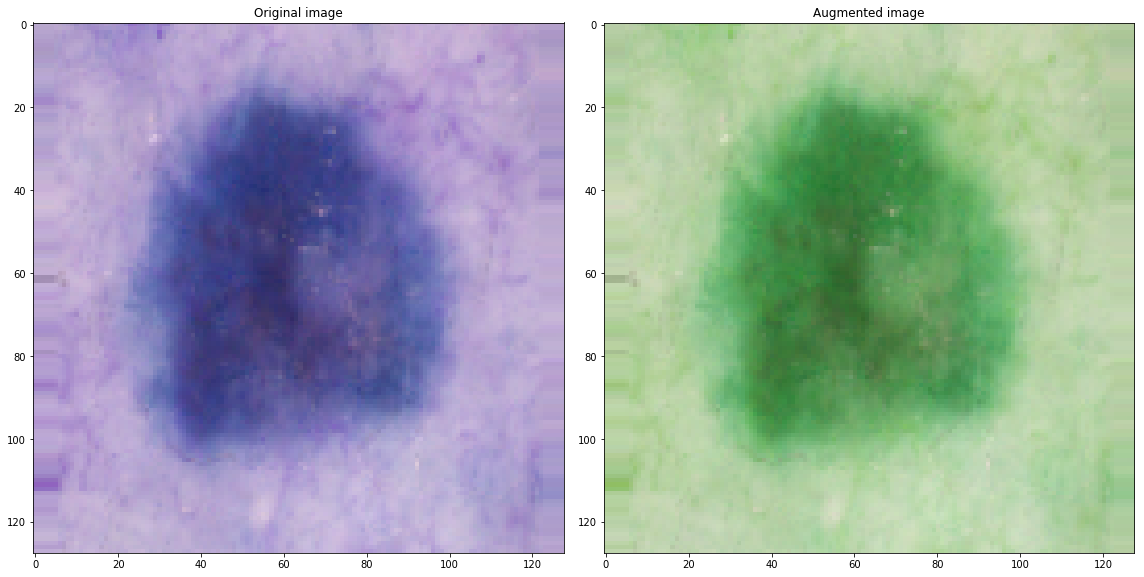

In [46]:
r = augment_and_show(strong, image, filename = './transforms/augmented_image_strong')

source: https://github.com/albu/albumentations/blob/master/notebooks/example.ipynb

In [51]:
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, RandomBrightnessContrast, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, Flip, OneOf, Compose
)

In [52]:
def strong_aug(p=.5):
    return A.Compose([
        RandomRotate90(),
        Flip(),
        Transpose(),
        OneOf([
            IAAAdditiveGaussianNoise(),
            GaussNoise(),
        ], p=0.2),
        OneOf([
            MotionBlur(p=.2),
            MedianBlur(blur_limit=3, p=0.1),
            Blur(blur_limit=3, p=0.1),
        ], p=0.2),
        ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.2),
        OneOf([
            OpticalDistortion(p=0.3),
            GridDistortion(p=.1),
            IAAPiecewiseAffine(p=0.3),
        ], p=0.2),
        OneOf([
            CLAHE(clip_limit=2),
            IAASharpen(),
            IAAEmboss(),
            RandomBrightnessContrast(),            
        ], p=0.3),
        HueSaturationValue(p=0.3),
    ], p=p)

In [42]:
def augment_and_show(aug, image, verbose = True ):
    image = aug(image=image)['image']
    if verbose: 
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
    return image 

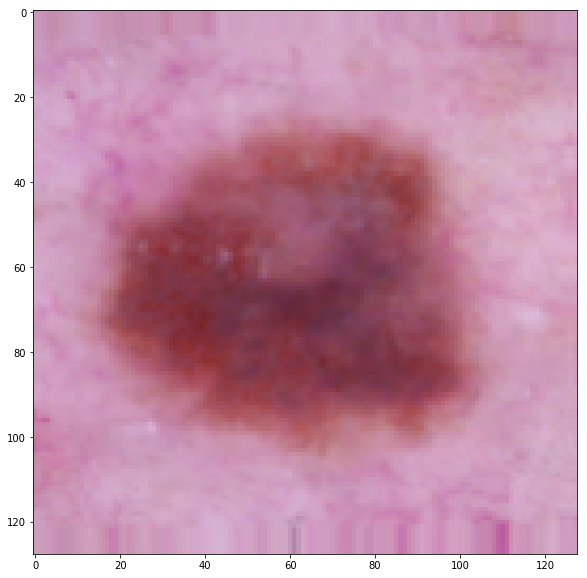

In [72]:
aug = strong_aug(p=1)
image_aug = augment_and_show(aug, image)

## DO NOT RUN AGAIN

In [83]:
from skimage import img_as_ubyte
from skimage import img_as_float

""" PROBLEM MEMORY """

def augment_data(X, Y, class_label = 1, filename = None ):
    """
    PARAMS
    --------------
    class_label: int 
    label of the observations that must be replicated: class mel of label 1 here 
    
    filename: list 
    list[0] = file_X, list[1] = file_Y
    
    X, Y: numpy array
    data that must be augmented symmetrically
    
    Returns
    -------------------
    Augmented data X_aug, Y_aug
    """
    
    X_copy = np.copy(X)
    Y_copy = np.copy(Y)
    iteration = 0
    for i in range(X.shape[0]):
        iteration += 1
        if iteration % 500 == 0:
            print("==========================")
            print("Nice! {} steps done already :) ".format(iteration))
       
        label = Y[i]
        if label == class_label: ## class mel 
            ## we replicate 6 times with different ways 
            image = X[i]
            # transform to uint8 
            image = img_as_ubyte(image)
            for k in range(6):
                aug = strong_aug(p=1) # random transform of the image
                # transform it 
                image_aug = augment_and_show(aug, image, verbose = False)
                # convert image in float before adding in to data set 
                image_aug = img_as_float(image_aug)
                # add image to data set: each row is a new image so axis = 0
                image_aug = image_aug.reshape(1,128,128,3)
                X_copy = np.append(X_copy, image_aug, axis = 0)
                Y_copy = np.append(Y_copy, np.array([label]), axis = 0)
                
    if filename is not None:
        filename_data, filename_label = filename[0], filename[1]
        np.save(filename_data, X_copy)
        np.save(filename_label, Y_copy)
    
    return X_copy, Y_copy

## DO NOT RUN AGAIN

In [102]:
from skimage import img_as_ubyte
from skimage import img_as_float

""" SOLUTION """

def augment_data_mel(X, Y, class_label = 1, filename = None ):
    """
    PARAMS
    --------------
    class_label: int 
    label of the observations that must be replicated: class mel of label 1 here 
    
    filename: list 
    list[0] = file_X, list[1] = file_Y
    
    X, Y: numpy array
    data that must be augmented symmetrically
    
    Returns
    -------------------
    Augmented data X_aug, Y_aug
    """
    n_mel = 698 # nb of instances of mel in training data
    n_new = 6*n_mel
    X_new = np.ones((n_new, 128, 128, 3))
    Y_new = np.ones((n_new,))
    
    index_mel = np.where( Y == class_label ) # by default it is mel 
    X_mel = X[index_mel]
    
    iter_mel = 0
    for i in range(X_mel.shape[0]):
        if i%500 == 0 and i!=0:
            print("==========================")
            print("Nice! {} images augmented already :) ".format(i))
        
        ## we replicate 6 times with different ways 
        image = X_mel[i]
        # transform to uint8 
        image = img_as_ubyte(image)
        for k in range(6):
            aug = strong_aug(p=1) # random transform of the image
            # transform it 
            image_aug = augment_and_show(aug, image, verbose = False)
            # convert image in float before adding in to data set 
            image_aug = img_as_float(image_aug)
            # add image to data set: each row is a new image so axis = 0
            image_aug = image_aug.reshape(1,128,128,3)

            X_new[iter_mel] = image_aug
            Y_new[iter_mel] = class_label
            iter_mel += 1
            
            
    if filename is not None:
        filename_data, filename_label = filename[0], filename[1]
        np.save(filename_data, X_new)
        np.save(filename_label, Y_new)
        
    return X_new, Y_new

In [ ]:
filename_aug_strong_X, filename_aug_strong_Y = "./data_keras/X_train_aug_strong.npy" , "./data_keras/Y_train_aug_strong.npy"
filename_arr = [filename_aug_strong_X, filename_aug_strong_Y]

X_train_aug_strong, Y_train_aug_strong = augment_data_mel(x_train, y_train, class_label = 1, filename = filename_arr )

In [14]:
import gc
def clean_variables():
    gc.collect()

In [6]:
### LOAD STRONGLY AUGMENTED DATA FOR MEL CLASS #### 
filename_mel_strong_X, filename_mel_strong_Y = "./data_keras/X_train_mel_strong.npy" , "./data_keras/Y_train_mel_strong.npy"
# np.save(filename_mel_strong_X, X_train_aug_strong)
# np.save(filename_mel_strong_Y, Y_train_aug_strong)

X_train_aug_mel = np.load(filename_mel_strong_X)
Y_train_aug_mel = np.load(filename_mel_strong_Y)

In [75]:
y_train.shape[0], Y_train_aug_mel.shape[0]

(4988, 4188)

In [14]:
########## Customize Early Stopping ###########
from keras.callbacks import Callback

class EarlyStoppingByAccuracy(Callback):
    """
    When checking the logs we see that sometimes we get a very low val loss/ high val accuracy at some epoch and after we go below such values.
    Solution:  We will check when such accuracy is reached and stop at this very moment 
    
    PARAMS
    --------------------------
    value: int v
    Value that is seen to be passed for a given epoch => If we are beyond it we stop training!! 
    
    """
    def __init__(self, monitor='accuracy', value=0.85, verbose=0):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)

        if current >= self.value:
            if self.verbose > 0:
                print("Epoch %05d: early stopping THR" % epoch)
            self.model.stop_training = True

In [7]:

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from collections import Counter 
from keras import backend as K
from keras import optimizers
from keras.callbacks import CSVLogger
from keras.callbacks import ModelCheckpoint


csv_logger = CSVLogger('log.csv', append=True, separator=';')



def evaluate_classifier_conv_custom(x_train = x_train, y_train = y_train, x_val = x_val, y_val = y_val, img_rows = 128, img_cols = 128, batch_size = 32, epochs = 20, learning_rate = 0.01, dropout = 0.7, log = True, threshold_acc = 0.87):
    """
    Create simple convolutional model to classify data
    Fit data and return fitted model 
    
    Custom callback
    """
    
    K.clear_session()
    np.random.seed(100)

    if K.image_data_format() == 'channels_first':
        x_train = x_train.reshape(x_train.shape[0], 3, img_rows, img_cols)
        x_val = x_val.reshape(x_val.shape[0], 3, img_rows, img_cols)
        input_shape = (3, img_rows, img_cols)
    else:
        x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 3)
        x_val = x_val.reshape(x_val.shape[0], img_rows, img_cols, 3)
        input_shape = (img_rows, img_cols, 3)

    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=(128, 128,3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))


    # initiate RMSprop optimizer
    opt = optimizers.rmsprop(lr=learning_rate, decay = 1e-5)

    model.compile(loss='binary_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    
    kfold_weights_path = "best_model{}.hdf5".format(3)
    callbacks = [
                EarlyStoppingByAccuracy(monitor='val_acc', value=threshold_acc, verbose=1), # early stopping based on validation accuracy 
                ModelCheckpoint(kfold_weights_path, monitor='val_loss', save_best_only=True, verbose=0)
                
                ]

    if log:
        callbacks.append(csv_logger)
        # Fit data 
        model.fit(x_train, y_train,
                  batch_size=batch_size,
                  epochs=epochs,
                  verbose=1,
                  validation_data=(x_val, y_val),
                    callbacks = callbacks)
        
    else:
        
        # Fit data 
        model.fit(x_train, y_train,
                  batch_size=batch_size,
                  epochs=epochs,
                  verbose=1,
                  validation_data=(x_val, y_val),
                  callbacks = callbacks)

        
    # Compute final performance on validation data
    score = model.evaluate(x_val, y_val, verbose=0)
    print('Final validation loss:', score[0])
    print('Final validation accuracy:', score[1])
    
    return model  

In [39]:
##### PARAMS FOR AUGMENTED DATASET #####
model_params_aug = { 
                    "x_train": X_aug, 
                    "y_train": Y_aug, 
                    "x_val": x_val, 
                    "y_val": y_val,
                    "img_rows": 128,
                    "img_cols": 128, 
                    "batch_size": 16, 
                    "epochs": 40, 
                    "learning_rate": 0.0001, 
                    "dropout": 0.50,
                    "log":False,
                    "threshold_acc": 0.87
                    }

csv_logger = CSVLogger('log_conv_strong_augOK3.csv', append=True, separator=';')

In [ ]:
model_strong_conv = evaluate_classifier_conv_custom(**model_params_aug)

In [ ]:
### LOAD BEST MODEL ###
from keras.models import load_model

filename_best_model = "best_model{}.hdf5".format(2)
model_best2 = load_model(filename_best_model)
model_best2.evaluate(x_val, y_val)

In [8]:
def plot_graphs(model = model_best2, nb_epochs = 6) -> None:
    
    dict_history = model.history.history
    train_costs, val_costs = dict_history['loss'], dict_history['val_loss']
    acc_arr_train, acc_arr_val = dict_history['acc'], dict_history['val_acc']
    ########  Cross-entropy  ###########
    plt.figure(figsize = (15,10))
    ax = plt.gca()

    epochs = range(nb_epochs)
    ax.plot(epochs, train_costs, color = "green")
    ax.plot(epochs, val_costs, color = "purple")
    ax.grid(True)
    ax.set_ylabel("Cross-entropy",fontsize=14, color='blue')
   

    plt.title("Training and Validation cross-entropy vs epochs ", fontsize = 15)
    plt.show()
    #########  Accuracy #############
    plt.figure(figsize = (15,10))
    ax = plt.gca()
    ax2 = ax.twinx()

    epochs = range(nb_epochs)
    ax.plot(epochs, acc_arr_train, color = "green") 
    ax.plot(epochs, acc_arr_val, color = "purple")
    ax.grid(True)
    ax.set_ylabel("accuracy",fontsize=14,color='green')


    plt.title("Training and Validation accuracy vs epochs ", fontsize = 15)
    plt.show()
    return ;

In [11]:
def acc_val_mel_nv(model) -> None:
    index_nv_val = np.where( y_val == 0 )
    index_mel_val = np.where( y_val == 1 )

    score_nv = model.evaluate(x_val[index_nv_val], y_val[index_nv_val], verbose=0)
    score_mel = model.evaluate(x_val[index_mel_val], y_val[index_mel_val], verbose=0)

    print("============ Class NV: aug ========= ")
    print("Accuracy on images on nv class fromn validation data: {}".format(score_nv[1]))

    print("============ Class MEL: aug ========= ")
    print("Accuracy on images on mel class fromn validation data: {}".format(score_mel[1]))

In [12]:
acc_val_mel_nv(model_best2)

============ Class NV: aug ========= 
Accuracy on images on nv class fromn validation data: 0.9187145557655955
============ Class MEL: aug ========= 
Accuracy on images on mel class fromn validation data: 0.6526315758102819


In [17]:
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score


def compute_recall(model):
    Y_pred = model.predict_classes(x_val)
    
    recall_strong = recall_score(y_val, Y_pred.reshape(-1,))
    print ("Recall on class MEL is {}".format(recall_strong))
    return recall_strong
    
def compute_fscore(model):
    Y_pred = model.predict_classes(x_val)
    f1_val = f1_score(y_true = y_val, y_pred = Y_pred)
    print ("F1 score on class MEL with validation data is {}".format(f1_val))
    return f1_val

In [18]:
compute_recall(model = model_best2)

Recall on class MEL is 0.6526315789473685


0.6526315789473685

In [19]:
compute_fscore(model = model_best2 )

F1 score on class MEL with validation data is 0.6200000000000001


0.6200000000000001

In [31]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(model, x_val = x_val, y_val = y_val, classes = np.array([0,1]),
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    
    y_pred = model.predict_classes(x_val)
    y_true = y_val 
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#     print(cm)
    
    fig, ax = plt.subplots(figsize = (15,10))
    #fig = plt.figure((15,10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

# Plot non-normalized confusion matrix
# plot_confusion_matrix(model_best2)

# Plot normalized confusion matrix
# plot_confusion_matrix(model_best2, normalize = True)

# plt.show()

In [ ]:
index_nv_val = np.where( y_val == 0 )
index_mel_val = np.where( y_val == 1 )

score_nv = model_strong_conv.evaluate(x_val[index_nv_val], y_val[index_nv_val], verbose=0)
score_mel = model_strong_conv.evaluate(x_val[index_mel_val], y_val[index_mel_val], verbose=0)

print("============ Class NV: aug ========= ")
print("Accuracy on images on nv class fromn validation data: {}".format(score_nv[1]))

print("============ Class MEL: aug ========= ")
print("Accuracy on images on mel class fromn validation data: {}".format(score_mel[1]))

In [51]:
"""
@COMPILE: define a specific metric for unbalanced data 
"""

def recall_np(y_true, y_pred):
    """Recall metric
    Only computes a batch-wise average of recall. Computes the recall, a metric
    for multi-label classification of how many relevant items are selected.
    """
    epsilon = np.finfo(np.float32).eps
    y_pred = y_pred.reshape(-1,)
    true_positives = np.sum(y_true * y_pred)
    print(true_positives)
    possible_positives = np.sum(y_true)
    recall = true_positives / (possible_positives + epsilon)
    return recall

In [27]:
Y_pred = model_strong_conv.predict_classes(x_val)
from sklearn.metrics import recall_score
recall_strong = recall_score(y_val, Y_pred.reshape(-1,))
print ("Recall on class MEL is {}".format(recall_strong))

Recall on class MEL is 0.5842105263157895


In [28]:
from sklearn.metrics import f1_score

f1_val = f1_score(y_true = y_val, y_pred = Y_pred)
print ("F1 score on class MEL with validation data is {}".format(f1_val))

F1 score on class MEL with validation data is 0.5606060606060606


## AUGMENT CLASS NV 

In [55]:
from skimage import img_as_ubyte
from skimage import img_as_float

""" SOLUTION """

def augment_data_nv(X, Y, class_label = 0, factor = 2, filename = None ):
    """
    PARAMS
    --------------
    class_label: int 
    label of the observations that must be replicated: class nv of label 0 here 
    
    filename: list 
    list[0] = file_X, list[1] = file_Y
    
    X, Y: numpy array
    data that must be augmented symmetrically
    
    Returns
    -------------------
    Augmented data X_aug, Y_aug
    """
    n_nv = 4290 # nb of instances of mel in training data
    n_new = factor*n_nv
    X_new = np.ones((n_new, 128, 128, 3))
    Y_new = np.ones((n_new,))
    
    index_nv = np.where( Y == class_label ) # by default it is mel 
    X_nv = X[index_nv]
    
    iter_nv = 0
    for i in range(X_nv.shape[0]):
        if i%500 == 0 and i!=0:
            print("==========================")
            print("Nice! {} images augmented already :) ".format(i))
        
        ## we replicate 2 times with different ways 
        image = X_nv[i]
        # transform to uint8 
        image = img_as_ubyte(image)
        for k in range(factor):
            aug = strong_aug(p=1) # random transform of the image
            # transform it 
            image_aug = augment_and_show(aug, image, verbose = False)
            # convert image in float before adding in to data set 
            image_aug = img_as_float(image_aug)
            # add image to data set: each row is a new image so axis = 0
            image_aug = image_aug.reshape(1,128,128,3)

            X_new[iter_nv] = image_aug
            Y_new[iter_nv] = class_label
            iter_nv += 1
            
            
    if filename is not None:
        filename_data, filename_label = filename[0], filename[1]
        np.save(filename_data, X_new)
        np.save(filename_label, Y_new)
        
    return X_new, Y_new

In [56]:
filename_aug_strong_X, filename_aug_strong_Y = "./data_keras/X_nv_strong.npy" , "./data_keras/Y_nv_strong.npy"
filename_arr = [filename_aug_strong_X, filename_aug_strong_Y]

X_nv_strong, Y_nv_strong = augment_data_nv( x_train, y_train, class_label = 0, factor = 2, filename = filename_arr )

Nice! 500 images augmented already :) 
Nice! 1000 images augmented already :) 
Nice! 1500 images augmented already :) 
Nice! 2000 images augmented already :) 
Nice! 2500 images augmented already :) 
Nice! 3000 images augmented already :) 
Nice! 3500 images augmented already :) 
Nice! 4000 images augmented already :) 


## AUGMENTED DATA WITH STACKED AUTOENCODER

In [6]:
### LOAD DATA ####
filename_stack_aug = './data_keras/stacked_vae_normdist_3499-8-8-32-30.npy'
X_mel_stack_aug = np.load(filename_stack_aug)

In [18]:
### ADD AUGMENTED DATA FOR CLASS MEL TO TRAINING DATA ###

## GOAL: just stack the augmented mel data with training data and shuffle 
# PROBLEM: memory error 
# Solution: Pre allocate memory by stating shape of matrix 

### nb_obs = nb observations total so obs in X1 + obs in X2
def concat_train_label(X1, X2 , Y1, Y2):
    nb_obs = X1.shape[0] + X2.shape[0]
    X_aug = np.empty((nb_obs, 128, 128, 3))
    Y_aug = np.empty((nb_obs,))
    nb_obs_or = X1.shape[0]
    
    for k in range(X1.shape[0]):
        X_aug[k] = X1[k]
        Y_aug[k] = Y1[k]
    
    iteration = 0
    while iteration != Y2.shape[0]:
        X_aug[iteration+nb_obs_or] = X2[iteration]
        Y_aug[iteration+nb_obs_or] = Y2[iteration]
        iteration += 1
        
    return X_aug, Y_aug

X_aug, Y_aug = concat_train_label(x_train, X_mel_stack_aug, y_train, np.ones(X_mel_stack_aug.shape[0], ))

# # ## Shuffle data ##
X_aug, Y_aug = shuffle_data(X_aug, Y_aug)

In [11]:
##### PARAMS FOR AUGMENTED DATASET #####
model_params_aug = { 
                    "x_train": X_aug, 
                    "y_train": Y_aug, 
                    "x_val": x_val, 
                    "y_val": y_val,
                    "img_rows": 128,
                    "img_cols": 128, 
                    "batch_size": 16, 
                    "epochs": 40, 
                    "learning_rate": 0.0001, 
                    "dropout": 0.50,
                    "log":False,
                    "threshold_acc": 0.86
                    }

csv_logger = CSVLogger('log_conv_strong_augOK3.csv', append=True, separator=';')

In [ ]:
model__conv = evaluate_classifier_conv_custom(**model_params_aug)

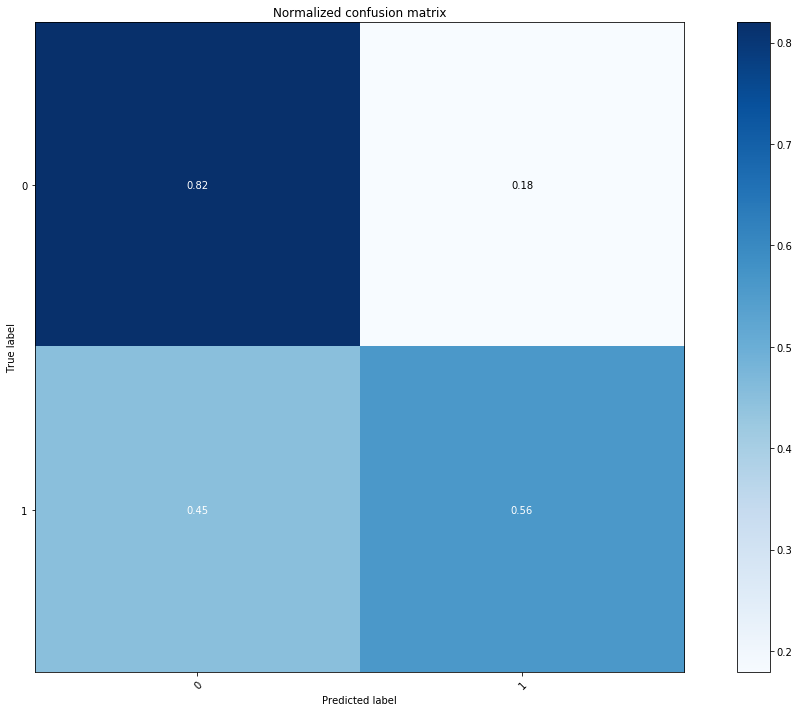

In [14]:
# Plot normalized confusion matrix
plot_confusion_matrix(model__conv, normalize = True)

plt.show()

### CUSTOM EARLY STOPPING BASED ON FSCORE 

In [6]:
"""
@COMPILE: define a specific metric for unbalanced data 
"""

def recall_np(y_true, y_pred):
    """Recall metric
    Only computes a batch-wise average of recall. Computes the recall, a metric
    for multi-label classification of how many relevant items are selected.
    """
    epsilon = np.finfo(np.float32).eps
    y_pred = y_pred.reshape(-1,)
    true_positives = np.sum(y_true * y_pred)
    print(true_positives)
    possible_positives = np.sum(y_true)
    recall = true_positives / (possible_positives + epsilon)
    return recall


def precision(y_true, y_pred):
    prod = y_true * y_pred
    nb_common_ones = np.sum(prod)
    nb_pred_ones = np.sum(y_pred)
    precision = nb_common_ones/nb_pred_ones
    return precision 

def f_score_main(y_true, y_pred): 
    """
    fscore = 2(recall*precision)/(recall + precision)
    """
    recall = recall_np(y_true, y_pred)
    precision = precision(y_ture, y_pred)
    return 2*(precision*recall)/(precision+recall)


In [26]:
import tensorflow as tf 
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from collections import Counter 
from keras import backend as K
from keras import optimizers
from keras.callbacks import CSVLogger
from keras.callbacks import ModelCheckpoint

from keras.callbacks import Callback

from sklearn.metrics import f1_score


csv_logger = CSVLogger('log.csv', append=True, separator=';')



    
    
class EarlyStopByF1(Callback):
    def __init__(self, value = 0, verbose = 0):
        super(Callback, self).__init__()
        self.value = value
        self.verbose = verbose

    def f1(self, y_true, y_pred):
        def recall(y_true, y_pred):
            """Recall metric.

            Only computes a batch-wise average of recall.

            Computes the recall, a metric for multi-label classification of
            how many relevant items are selected.
            """
            true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
            possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
            recall = true_positives / (possible_positives + K.epsilon())
            return recall

        def precision(y_true, y_pred):
            """Precision metric.

            Only computes a batch-wise average of precision.

            Computes the precision, a metric for multi-label classification of
            how many selected items are relevant.
            """
            true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
            predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
            precision = true_positives / (predicted_positives + K.epsilon())
            return precision
        precision = precision(y_true, y_pred)
        recall = recall(y_true, y_pred)
        return 2*((precision*recall)/(precision+recall+K.epsilon()))
    
    
    def on_epoch_end(self, epoch, logs={}):
        predict = np.asarray(self.model.predict(self.validation_data[0]))
        target = self.validation_data[1]
        predict = tf.convert_to_tensor(predict, tf.float32)
        target = tf.convert_to_tensor(target, tf.float32)
        score = self.f1(target, predict) # score is now a tf.tensor (necessary for early stopping)
#         print (type(score)) # tensor 
        tensor_value = tf.constant(self.value, shape = (1,))
        with tf.Session() as sess:
            tensor_value_score = sess.run(tf.greater(score, tensor_value))
#             print(sess.run(tf.greater(score, tensor_value))) ## prints [True] when we go beyond self.value
 
        if np.all(tensor_value_score):# if we go beyond our value, we can stop 
            if self.verbose > 0: # print
                print("Epoch %05d: early stopping Threshold" % epoch)
            self.model.stop_training = True


########## Customize Early Stopping ###########
from keras.callbacks import Callback

class EarlyStoppingByAccuracy(Callback):
    """
    When checking the logs we see that sometimes we get a very low val loss/ high val accuracy at some epoch and after we go below such values.
    Solution:  We will check when such accuracy is reached and stop at this very moment 
    
    PARAMS
    --------------------------
    value: int v
    Value that is seen to be passed for a given epoch => If we are beyond it we stop training!! 
    
    """
    def __init__(self, monitor='accuracy', value=0.85, verbose=0):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)

        if current >= self.value:
            if self.verbose > 0:
                print("Epoch %05d: early stopping THR" % epoch)
            self.model.stop_training = True
            
def evaluate_classifier_conv_custom_fscore(x_train, y_train, x_val, y_val, img_rows = 128, img_cols = 128, 
                                           batch_size = 32, epochs = 20, learning_rate = 0.01, 
                                           dropout = 0.7, log = True, threshold_acc = 0.87, name_model = 'stack', threshold_fscore = 0.5):
    """
    Create simple convolutional model to classify data
    Fit data and return fitted model 
    
    Custom callback
    """
    
    K.clear_session()
    np.random.seed(100)

    if K.image_data_format() == 'channels_first':
        x_train = x_train.reshape(x_train.shape[0], 3, img_rows, img_cols)
        x_val = x_val.reshape(x_val.shape[0], 3, img_rows, img_cols)
        input_shape = (3, img_rows, img_cols)
    else:
        x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 3)
        x_val = x_val.reshape(x_val.shape[0], img_rows, img_cols, 3)
        input_shape = (img_rows, img_cols, 3)

    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=(128, 128,3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    
    def recall(y_true, y_pred):
            """Recall metric.

            Only computes a batch-wise average of recall.

            Computes the recall, a metric for multi-label classification of
            how many relevant items are selected.
            """
            true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
            possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
            recall = true_positives / (possible_positives + K.epsilon())
            return recall
    
    def f1(y_true, y_pred):
        def recall(y_true, y_pred):
            """Recall metric.

            Only computes a batch-wise average of recall.

            Computes the recall, a metric for multi-label classification of
            how many relevant items are selected.
            """
            true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
            possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
            recall = true_positives / (possible_positives + K.epsilon())
            return recall

        def precision(y_true, y_pred):
            """Precision metric.

            Only computes a batch-wise average of precision.

            Computes the precision, a metric for multi-label classification of
            how many selected items are relevant.
            """
            true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
            predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
            precision = true_positives / (predicted_positives + K.epsilon())
            return precision
        precision = precision(y_true, y_pred)
        recall = recall(y_true, y_pred)
        return 2*((precision*recall)/(precision+recall+K.epsilon()))



    # initiate RMSprop optimizer
    opt = optimizers.rmsprop(lr=learning_rate, decay = 1e-5)

    model.compile(loss='binary_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy', f1, recall])
    
    
    kfold_weights_path = "best_model{}.hdf5".format(name_model)
    callbacks = [
                EarlyStoppingByAccuracy(monitor='val_acc', value=threshold_acc, verbose=1), # early stopping based on validation accuracy 
                ModelCheckpoint(kfold_weights_path, monitor='f1', save_best_only=True, verbose=0),
                EarlyStopByF1(value = threshold_fscore, verbose = 1) # early stopping based on f1 score
                ]

    if log:
        callbacks.append(csv_logger)
        # Fit data 
        model.fit(x_train, y_train,
                  batch_size=batch_size,
                  epochs=epochs,
                  verbose=1,
                  validation_data=(x_val, y_val),
                    callbacks = callbacks)
        
    else:
        
        # Fit data 
        model.fit(x_train, y_train,
                  batch_size=batch_size,
                  epochs=epochs,
                  verbose=1,
                  validation_data=(x_val, y_val),
                  callbacks = callbacks)

        
    # Compute final performance on validation data
    score = model.evaluate(x_val, y_val, verbose=0)
    print('Final validation loss:', score[0])
    print('Final validation accuracy:', score[1])
    
    return model  

In [ ]:
##### PARAMS FOR AUGMENTED DATASET #####
## We add early stopping based on f score 
model_params_aug_custom = { 
                    "x_train": X_aug, 
                    "y_train": Y_aug, 
                    "x_val": x_val, 
                    "y_val": y_val,
                    "img_rows": 128,
                    "img_cols": 128, 
                    "batch_size": 16, 
                    "epochs": 2, 
                    "learning_rate": 0.0001, 
                    "dropout": 0.7,
                    "log":False,
                    "threshold_acc": 0.86, 
                    "name_model" : 'stack', 
                    "threshold_fscore" : 0.4
                    }

csv_logger = CSVLogger('log_conv_strong_augOK3.csv', append=True, separator=';')

In [ ]:
model_stack_conv = evaluate_classifier_conv_custom_fscore(**model_params_aug_custom)

## AUGMENTED DATA WITH CONVOLUTIONAL VAE 

In [20]:
###### LOAD DATA GENERATED FROM VAE ##########

### --------- CLASS MEL ---------- ####

filename_mel_VAE = "./augmented_data/images_VAE_mel_10000.npy"
x_mel_aug_VAE = np.load(filename_mel_VAE)
print ("-------- LOAD VAE DATA : class MEL ------------")
print('Nb of observations generated for this class: {}'.format(x_mel_aug_VAE.shape[0]))
#######################################


### --------- CLASS NV ---------- ####
filename_nv_VAE = "./augmented_data/images_VAE_nv.npy"
x_nv_aug_VAE = np.load(filename_nv_VAE)
print ("-------- LOAD VAE DATA : class NV ------------")
print('Nb of observations generated for this class: {}'.format(x_nv_aug_VAE.shape[0]))
#######################################

-------- LOAD VAE DATA : class MEL ------------
Nb of observations generated for this class: 9261
-------- LOAD VAE DATA : class NV ------------
Nb of observations generated for this class: 4913


### CLASSIFICATION WITH ONLY AUGMENTED DATA

#### DATA 

In [2]:
####### RECALL: DATA ORIGINAL FOR BOTH CLASSES  #######

###### MEL: class 1 ######
x_mel_train, x_mel_test = np.load("./dataset/train_mel.npy"), np.load("./dataset/test_mel.npy")
y_mel_train, y_mel_test = np.ones((x_mel_train.shape[0], )), np.ones((x_mel_test.shape[0], ))


###### NV: class 0 ######
x_nv_train, x_nv_test = np.load("./dataset/train_nv.npy"), np.load("./dataset/test_nv.npy")
y_nv_train, y_nv_test = np.zeros((x_nv_train.shape[0], )), np.zeros((x_nv_test.shape[0], ))

In [12]:
### VALIDATION ORIGINAL DATASET MIX CLASSES ###### 

##### We need to concatenate also x_mel_test and y_mel_test ###### 
x_val_org, y_val_org = concat_train_label(x_mel_test, x_nv_test, y_mel_test, y_nv_test)
x_val_org, y_val_org = shuffle_data(x_val_org, y_val_org)

In [17]:
x_train_org, y_train_org = concat_train_label(x_mel_train, x_nv_train, y_mel_train, y_nv_train)
x_train_org, y_train_org = shuffle_data(x_train_org, y_train_org)

In [10]:
#### We are going to classify our images but using only augmented images from both classes ### 
### First, we shuffle data
### Second, we take the same nb of observations for both classes 
### Third, we concatenate those two classes and shuffle again the data

#### Shuffle data ####
y_mel_aug_VAE = np.ones((x_mel_aug_VAE.shape[0],))
x_mel_aug_VAE, _ = shuffle_data(x_mel_aug_VAE, y_mel_aug_VAE)

y_nv_aug_VAE = np.zeros((x_nv_aug_VAE.shape[0],))
x_nv_aug_VAE, _ = shuffle_data(x_nv_aug_VAE, y_nv_aug_VAE)

#### Take same nb of observations for both classes --- expected: 4,913 obs  #### 
x_mel_VAE, y_mel_VAE = x_mel_aug_VAE[np.arange(x_nv_aug_VAE.shape[0])], y_mel_aug_VAE[np.arange(x_nv_aug_VAE.shape[0])]

### Concatenate both arrays and shuffle the concatenate ### 
X_aug_only, Y_aug_only = concat_train_label(x_nv_aug_VAE, x_mel_VAE, y_nv_aug_VAE, y_mel_VAE)

## Shuffle data ##
X_aug_only, Y_aug_only = shuffle_data(X_aug_only, Y_aug_only)

In [11]:
####### AUGMENTED DATA MEL + ORG MEL ##########

### sample data from mel augmented until we have same nb of observations from class MEL and class NV ### 

### IF AUGMENTED MEL NOT SHUFFLED BEFORE ###
y_mel_aug_VAE = np.ones((x_mel_aug_VAE.shape[0],))
x_mel_aug_VAE, _ = shuffle_data(x_mel_aug_VAE, y_mel_aug_VAE)
#######################################
nb_obs_add = x_nv_train.shape[0]-x_mel_train.shape[0]
index_aug_mel = np.arange(nb_obs_add)
x_mel_aug_VAE_add = x_mel_aug_VAE[index_aug_mel] ## only take a certain nb of observations from MEL augmented dataset
y_mel_aug_VAE_add = np.ones((x_mel_aug_VAE_add.shape[0],)) ## mel of class 1

## concatenate MEL org with MEL aug : MIX org and augmented ==> Now, we have obs with aug and org of class MEL 
x_mel_train_mix, y_mel_train_mix =  concat_train_label(x_mel_train, x_mel_aug_VAE_add, y_mel_train, y_mel_aug_VAE_add)

In [10]:
x_mel_train_mix.shape

(5365, 128, 128, 3)

#### ONLY COMPUTE ONCE 

#### PARAMS 

In [24]:
##### PARAMS FOR AUGMENTED DATASET #####
## We add early stopping based on f score 
model_params_VAE_aug_custom = { 
                    "x_train": X_aug_only, 
                    "y_train": Y_aug_only, 
                    "x_val": x_val_org, 
                    "y_val": y_val_org,
                    "img_rows": 128,
                    "img_cols": 128, 
                    "batch_size": 32, 
                    "epochs": 20, 
                    "learning_rate": 0.0001, 
                    "dropout": 0.7,
                    "log":False,
                    "threshold_acc": 0.86, 
                    "name_model" : 'VAE_only', 
                    "threshold_fscore" : 0.5
                    }

csv_logger = CSVLogger('log_conv_strong_augOK3.csv', append=True, separator=';')

In [ ]:
#### CLASSIFY AUGMENTED DATA #######
model_VAE_conv = evaluate_classifier_conv_custom_fscore(**model_params_VAE_aug_custom)

In [ ]:
####### LOAD BEST MODEL THANKS TO MODELCHECKPOINT ##########
from keras.models import load_model

model_best_VAE_conv_AUG_only = load_model("./best_modelVAE_only.hdf5")

Confusion matrix, without normalization
Normalized confusion matrix


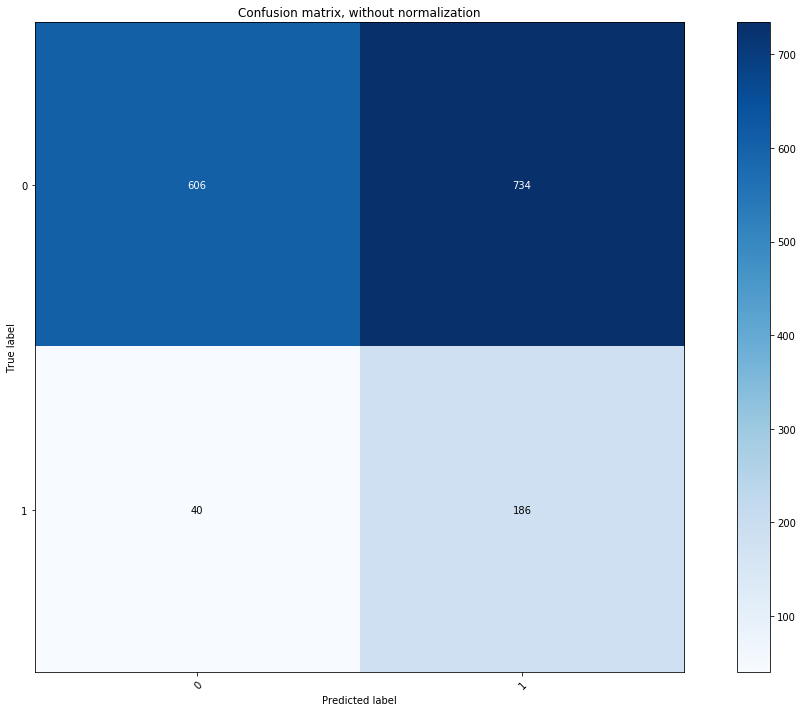

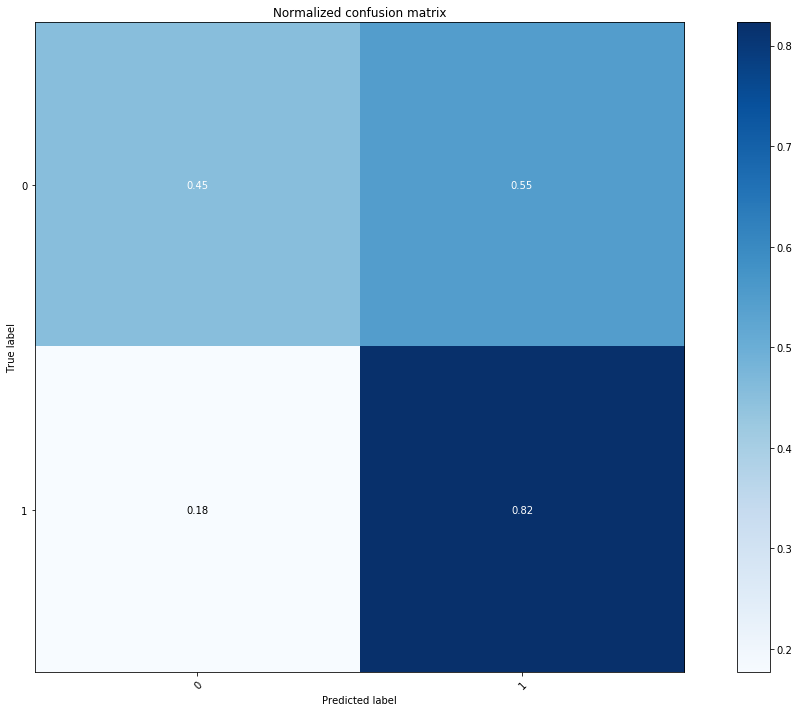

In [35]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(model_VAE_conv, x_val = x_val_org, y_val=y_val_org)

# Plot normalized confusion matrix
plot_confusion_matrix(model_VAE_conv, x_val = x_val_org, y_val=y_val_org, normalize = True)

plt.show()

### CLASSIFICATION WITH  AUGMENTED DATA FROM MEL ADDED TO ORIGINAL DATA

#### DATA 

In [12]:
### Concatenate both arrays and shuffle the concatenate ### 
X_aug_mix, Y_aug_mix = concat_train_label(x_nv_train, x_mel_train_mix, y_nv_train, y_mel_train_mix)

## Shuffle data ##
X_aug_mix, Y_aug_mix = shuffle_data(X_aug_mix, Y_aug_mix)

#### PARAMS 

In [21]:
##### PARAMS FOR AUGMENTED DATASET #####
## We add early stopping based on f score 
model_params_VAE_aug_custom_mix = { 
                    "x_train": X_aug_mix, 
                    "y_train": Y_aug_mix, 
                    "x_val": x_val_org,  # x_val 
                    "y_val": y_val_org, # y_val
                    "img_rows": 128,
                    "img_cols": 128, 
                    "batch_size": 32, 
                    "epochs": 5, 
                    "learning_rate": 1e-3, 
                    "dropout": 0.3,
                    "log":False,
                    "threshold_acc": 0.86, 
                    "name_model" : 'VAE_only', 
                    "threshold_fscore" : 0.8
                    }

csv_logger = CSVLogger('log_conv_strong_augOK3.csv', append=True, separator=';')

#### CLASSIFICATION

In [ ]:
#### CLASSIFY AUGMENTED DATA where MEL is from ORG and AUGMENTED_VAE  #######
model_VAE_conv_mix = evaluate_classifier_conv_custom_fscore(**model_params_VAE_aug_custom_mix)

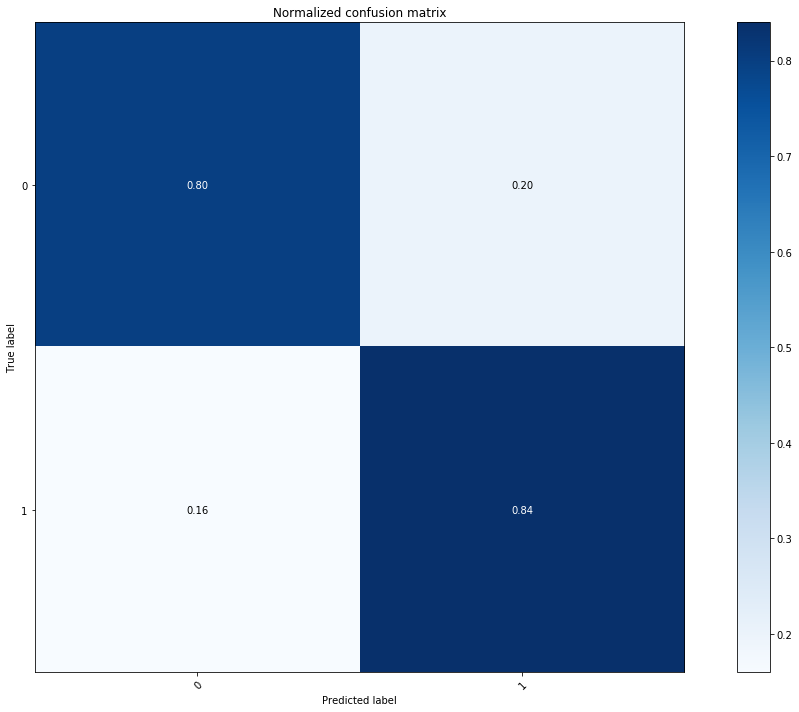

In [9]:
##### PLOT CONFUSION MATRIX ######

# Plot normalized confusion matrix
plot_confusion_matrix(model_VAE_conv_mix, x_val = x_val_org, y_val=y_val_org, normalize = True)

plt.show()

### SMART AUGMENTATION

In [39]:
###### LOAD DATA GENERATED FROM SMART VAE ##########

### --------- CLASS MEL ---------- ####

filename_mel_smart = "./augmented_data/images_smart_mel.npy"
x_mel_smart = np.load(filename_mel_smart)
print ("-------- LOAD VAE DATA : class MEL ------------")
print('Nb of observations generated for this class: {}'.format(x_mel_smart.shape[0]))
#######################################


-------- LOAD VAE DATA : class MEL ------------
Nb of observations generated for this class: 4913


In [40]:
####### AUGMENTED DATA MEL + ORG MEL ##########

### sample data from mel augmented until we have same nb of observations from class MEL and class NV ### 

## concatenate MEL org with MEL aug : MIX org and augmented ==> Now, we have obs with aug and org of class MEL 
x_mel_smart_mix, y_mel_smart_mix =  concat_train_label(x_mel_train, x_mel_smart, y_mel_train, np.ones(x_mel_smart.shape[0],))


X_aug_smart, Y_aug_smart  = concat_train_label(x_mel_smart_mix, x_nv_train, y_mel_smart_mix, y_nv_train)

X_aug_smart, Y_aug_smart  = shuffle_data(X_aug_smart, Y_aug_smart)

In [43]:
##### PARAMS FOR AUGMENTED DATASET #####
## We add early stopping based on f score 
model_params_smart_custom_mix = { 
                    "x_train": X_aug_smart, 
                    "y_train": Y_aug_smart, 
                    "x_val": x_val_org,  # x_val 
                    "y_val": y_val_org, # y_val
                    "img_rows": 128,
                    "img_cols": 128, 
                    "batch_size": 32, 
                    "epochs": 20, 
                    "learning_rate": 1e-5, 
                    "dropout": 0.3,
                    "log":False,
                    "threshold_acc": 0.86, 
                    "name_model" : 'VAE_only', 
                    "threshold_fscore" : 0.8
                    }

csv_logger = CSVLogger('log_conv_strong_augOK3.csv', append=True, separator=';')

### CLASSIFICATION WITH SMART_AUG_MEL + ORG

In [ ]:
#### CLASSIFY AUGMENTED DATA where MEL is from ORG and AUGMENTED_VAE  #######
model_VAE_smart_mix = evaluate_classifier_conv_custom_fscore(**model_params_smart_custom_mix)

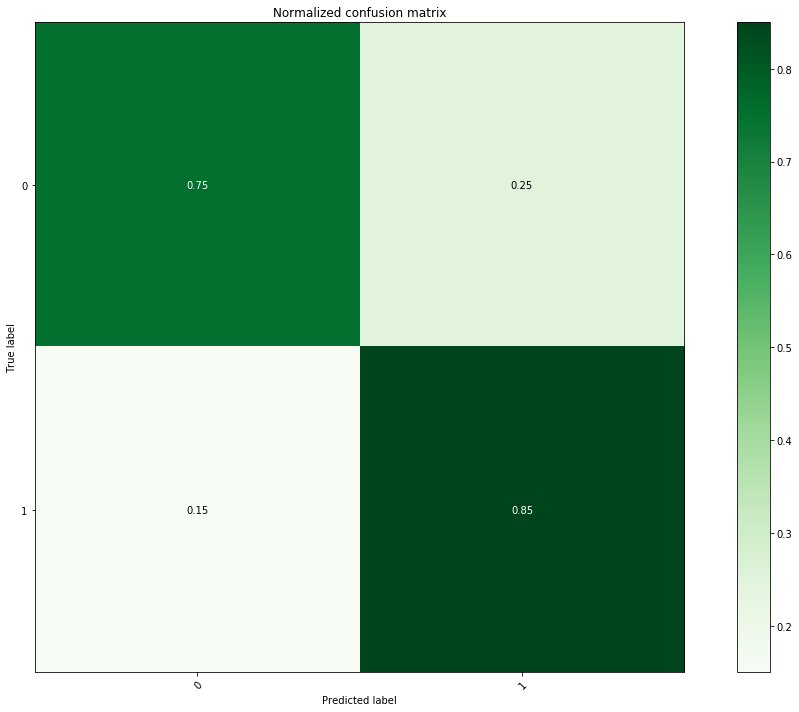

In [121]:
##### PLOT CONFUSION MATRIX IN GREEN ######

# Plot normalized confusion matrix
plot_confusion_matrix(model_VAE_smart_mix, x_val = x_val_org, y_val=y_val_org, normalize = True, cmap=plt.cm.Greens)

plt.show()

### CLASSIFICATION WITH SMART_AUG_MEL + VAE_AUG_NV +  ORG

In [ ]:
############# ADD NV agumented to data ##############

X_aug_smart, Y_aug_smart  = concat_train_label(X_aug_smart, x_nv_aug_VAE, Y_aug_smart, np.zeros(x_nv_aug_VAE.shape[0]))
X_aug_smart, Y_aug_smart = shuffle_data(X_aug_smart, Y_aug_smart)

### CLASSIFICATION WITH SIMPLE AUGMENTATION -- CHECK FSCORE ---

In [10]:
#### MEL augmented data from keras

x_train_mel = x_train[np.where(y_train == 1 )]
y_train_mel = np.ones((x_train_mel.shape[0],))


In [18]:
x_train_aug, y_train_aug = concat_train_label(x_train_org, x_train_mel, y_train_org, y_train_mel)
x_train_aug, y_train_aug = shuffle_data(x_train_aug, y_train_aug)

In [28]:
##### PARAMS FOR AUGMENTED DATASET #####
## We add early stopping based on f score 
model_params_simple_aug = { 
                    "x_train": x_train_aug, 
                    "y_train": y_train_aug, 
                    "x_val": x_val_org,  # x_val 
                    "y_val": y_val_org, # y_val
                    "img_rows": 128,
                    "img_cols": 128, 
                    "batch_size": 32, 
                    "epochs": 10, 
                    "learning_rate": 1e-3, 
                    "dropout": 0.3,
                    "log":False,
                    "threshold_acc": 0.86, 
                    "name_model" : 'simple_aug', 
                    "threshold_fscore" : 0.8
                    }

csv_logger = CSVLogger('log_conv_strong_augOK3.csv', append=True, separator=';')

In [29]:
model_simple = evaluate_classifier_conv_custom_fscore(**model_params_simple_aug)

Train on 6950 samples, validate on 1566 samples
Epoch 1/10
6950/6950 [==============================] - 47s 7ms/step - loss: 0.5232 - acc: 0.7679 - f1: 0.0092 - recall: 0.0143 - val_loss: 0.3917 - val_acc: 0.8557 - val_f1: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
6950/6950 [==============================] - 45s 7ms/step - loss: 0.4330 - acc: 0.7721 - f1: 0.0060 - recall: 0.0042 - val_loss: 0.4125 - val_acc: 0.8557 - val_f1: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/10
6950/6950 [==============================] - 45s 7ms/step - loss: 0.4123 - acc: 0.7755 - f1: 0.0449 - recall: 0.0348 - val_loss: 0.3491 - val_acc: 0.8557 - val_f1: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/10
6950/6950 [==============================] - 46s 7ms/step - loss: 0.4000 - acc: 0.7928 - f1: 0.3171 - recall: 0.2737 - val_loss: 0.3941 - val_acc: 0.8550 - val_f1: 0.1823 - val_recall: 0.1357
Epoch 5/10
6950/6950 [==============================] - 45s 7ms/step - loss: 0.3900 - acc: 0.7993 - f1: 0.4354 - rec